From one callsign, identify all the corresponding ATCO communications. 
idea:
 - Take a flight from A to B
 - identify which area / frequency they are contacting
 - download data from this frequency
 - Match the communications that were made with this flight

In [1]:
from typing import List
import re
from collections import Counter

from traffic.core import Traffic
from utils.cs_matching import build_timestamp_range, callsign_to_words
from utils.liveatc_utils import extract_timestamp_from_path

from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

adsb_path = "adsb/EPWA-epwa_app-Jun-27-2025-1830Z.parquet"
transcript_path = "transcripts/EPWA-epwa_app-Jun-27-2025-1830Z.txt"

adsb = Traffic.from_file(adsb_path)
timestamp_range = build_timestamp_range(adsb_path)
start_timestamp = extract_timestamp_from_path(transcript_path)

tokenizer = AutoTokenizer.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
model = AutoModelForTokenClassification.from_pretrained("Jzuluaga/bert-base-ner-atc-en-atco2-1h")
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="first")

Device set to use cpu


In [2]:
[callsign_to_words(cs) for cs in adsb.callsigns]

['aegean eight seven three',
 'lot two two six',
 'lot three mike alfa',
 'wizz air eight six three six',
 'lot three eight five nine',
 'ryan air six nine sierra quebec',
 'lot three nine seven',
 'lot seven alfa november',
 'jdi eight five hotel',
 'lot two charlie foxtrot',
 'wmt five five alfa charlie',
 'jet travel seven four one three',
 'speedbird eight lima victor',
 'ryan air one zero seven charlie',
 'lot five november golf',
 'lot six mike bravo',
 'wizz air three two lima juliett',
 'lot three lima xray',
 'lot two november charlie',
 'jet travel seven three one seven',
 'lot six kilo charlie',
 'lot six three nine',
 'ent five two november zulu',
 'efd six hotel',
 'lot six hotel tango',
 'aby six zero five',
 'lot three nine two one',
 'lot five echo november',
 'lot two eight five',
 'lot six papa alfa',
 'ent seven six golf foxtrot',
 'lot six three four zero',
 'lot three alfa victor',
 'tay two india xray',
 'lot three eight two five',
 'lot one kilo echo',
 'lot thre

air france two nine uniform kilo


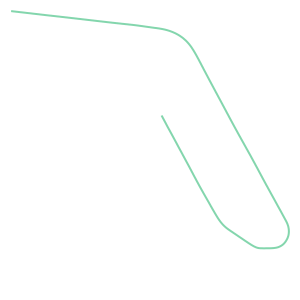

In [3]:
cs = "AFR29UK"
cs_word = callsign_to_words(cs)
print(cs_word)
adsb[cs]

In [4]:
# Is it rightully going through sector 16 ?
adsb[cs].map_leaflet()

Map(center=[52.117931114200694, 21.060773125630604], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [5]:
with open(transcript_path) as f:
    lines = [line.strip() for line in f if line.strip()]
    
for i, line in enumerate(lines):
    regex = re.match(r"\[(\d{2}:\d{2}:\d{2})\]\s*(.*)", line)
    timestamp = regex.group(1)
    sentence = regex.group(2)
    
    # Hard matching
    hard_match = cs_word in sentence
    if hard_match:
        print(f"[{i}]: {timestamp} {sentence} -> [Exact match]")
        continue
    
    # ATCO2 detection
    atco2_res = nlp(sentence)
    
    callsigns = [e for e in atco2_res if e['entity_group'] == 'callsign']
    if callsigns:
        top_callsign = max(callsigns, key=lambda e: e['score'])["word"]
        
        c1 = Counter(top_callsign.split())
        c2 = Counter(cs_word.split())
        overlap = sum((c1 & c2).values())
        if overlap > 1:
            if top_callsign in [callsign_to_words(cs) for cs in adsb.callsigns]:
                print(f"{top_callsign} corresponds to another aircraft")
                continue
            else:
                print(f"[{i}]: {timestamp} {sentence} -> [Detected callsign: {top_callsign}]")
        continue
    
 
        
    

[0]: 18:30:23 air france two nine uniform kilo no speed restrictions contact tower one eight decimal three zero five good day -> [Exact match]
[24]: 18:32:50 lot three eight five nine contact approach one two five decimal zero five five two five two five five czech air force three eight five nine -> [Detected callsign: czech air force three eight five nine]
[29]: 18:33:19 and air france six hotel are you able to reduce reduce no speed please one eight zero knots -> [Detected callsign: air france six]
[47]: 18:35:17 air berlin six two seven speed is one seventy fully established ils three three -> [Detected callsign: air berlin six two seven]
[54]: 18:36:45 air berlin two eight six hotel no speed restrictions contact tower one one eight decimal three zero five good day -> [Detected callsign: air berlin two eight six]
[146]: 18:55:01 three one nine zero three one two -> [Detected callsign: three one nine zero three one two]


In [9]:
# Some chunks are actually associated with 2 comunications. 
# EX: /home/kruu/git_folder/atc_clearences/chunks/EPWA-epwa_app-Jun-27-2025-1830Z/speech_024.wav
from pathlib import Path
from pydub import AudioSegment

chunk_dir = Path("chunks/EPWA-epwa_app-Jun-27-2025-1830Z")
chunk_files = sorted(chunk_dir.glob("*.wav"))
long = {}

for i, path in enumerate(chunk_files):
    chunk = AudioSegment.from_wav(path)
    length = len(chunk)/1000
    if length > 5:
        long[i] = length
    print(f"Duration {i}: {len(chunk)/1000:.2f} seconds")


Duration 0: 5.31 seconds
Duration 1: 1.05 seconds
Duration 2: 1.29 seconds
Duration 3: 1.95 seconds
Duration 4: 1.26 seconds
Duration 5: 4.26 seconds
Duration 6: 3.21 seconds
Duration 7: 2.85 seconds
Duration 8: 2.52 seconds
Duration 9: 2.91 seconds
Duration 10: 4.26 seconds
Duration 11: 3.24 seconds
Duration 12: 2.25 seconds
Duration 13: 2.16 seconds
Duration 14: 3.45 seconds
Duration 15: 2.67 seconds
Duration 16: 5.79 seconds
Duration 17: 3.99 seconds
Duration 18: 3.33 seconds
Duration 19: 1.95 seconds
Duration 20: 7.05 seconds
Duration 21: 6.42 seconds
Duration 22: 6.75 seconds
Duration 23: 6.33 seconds
Duration 24: 7.62 seconds
Duration 25: 4.26 seconds
Duration 26: 2.67 seconds
Duration 27: 4.56 seconds
Duration 28: 4.86 seconds
Duration 29: 5.88 seconds
Duration 30: 3.24 seconds
Duration 31: 2.58 seconds
Duration 32: 3.99 seconds
Duration 33: 2.49 seconds
Duration 34: 2.28 seconds
Duration 35: 1.92 seconds
Duration 36: 2.31 seconds
Duration 37: 5.13 seconds
Duration 38: 5.64 seco

In [12]:
long

{0: 5.31,
 16: 5.79,
 20: 7.05,
 21: 6.42,
 22: 6.75,
 23: 6.33,
 24: 7.62,
 29: 5.88,
 37: 5.13,
 38: 5.64,
 39: 6.03,
 42: 5.19,
 47: 5.28,
 48: 5.52,
 54: 5.19,
 56: 5.67,
 70: 7.5,
 80: 6.0,
 81: 5.04,
 86: 8.88,
 92: 6.66,
 93: 5.22,
 101: 6.78,
 102: 5.19,
 132: 5.43,
 135: 5.07,
 136: 5.7,
 140: 5.37,
 141: 6.18,
 153: 5.85,
 163: 6.12,
 179: 8.04,
 180: 5.19,
 191: 6.45,
 197: 6.42}

In [ ]:
# Diarization to discriminate different voices when several communications are in the same chunk

from pyannote.audio import Pipeline
import os

# Load pretrained speaker diarization pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token = os.getenv("HUGGINGFACE_TOKEN"))

# Run diarization
diarization = pipeline("/home/kruu/git_folder/atc_clearences/chunks/EPWA-epwa_app-Jun-27-2025-1830Z/speech_022.wav")

# Print segments with speaker labels
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"{turn.start:.1f}s - {turn.end:.1f}s: {speaker}")

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1+cu126. Bad things might happen unless you revert torch to 1.x.
0.0s - 6.7s: SPEAKER_00


In [ ]:
# TEST THE NEW PIPLINE WITH SPLITTING VAD USING DIARIZATION